# rnn-concise

本节将展示如何使用深度学习框架的高级API提供的函数更有效地实现相同的语言模型。


In [1]:
import tensorflow as tf
import math

from d2l import tensorflow as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## [**定义模型**]

高级API提供了循环神经网络的实现。
我们构造一个具有256个隐藏单元的单隐藏层的循环神经网络层`rnn_layer`。


tf.keras.layers.SimpleRNN(  
&nbsp;&nbsp;&nbsp;&nbsp;    units, activation='tanh', use_bias=True,    
&nbsp;&nbsp;&nbsp;&nbsp;    kernel_initializer='glorot_uniform',  
&nbsp;&nbsp;&nbsp;&nbsp;    recurrent_initializer='orthogonal',  
&nbsp;&nbsp;&nbsp;&nbsp;    bias_initializer='zeros', kernel_regularizer=None,  
&nbsp;&nbsp;&nbsp;&nbsp;    recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,  
&nbsp;&nbsp;&nbsp;&nbsp;    kernel_constraint=None, recurrent_constraint=None, bias_constraint=None,  
&nbsp;&nbsp;&nbsp;&nbsp;    dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False,  
&nbsp;&nbsp;&nbsp;&nbsp;    go_backwards=False, stateful=False, unroll=False, **kwargs  
)

In [2]:
num_hiddens = 256
rnn_cell = tf.keras.layers.SimpleRNNCell(num_hiddens,
    kernel_initializer='glorot_uniform',activation='relu')
rnn_layer = tf.keras.layers.RNN(rnn_cell, time_major=True,
    return_sequences=True, return_state=True)

In [3]:
state = rnn_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
state.shape

TensorShape([32, 256])

我们(**使用张量来初始化隐状态**)，它的形状是（隐藏层数，批量大小，隐藏单元数）。

In [4]:
X = tf.random.uniform((num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, len(state_new), state_new[0].shape

(TensorShape([35, 32, 256]), 32, TensorShape([256]))

[**通过一个隐状态和一个输入，我们就可以用更新后的隐状态计算输出。**]
需要强调的是，`rnn_layer`的“输出”（`Y`）不涉及输出层的计算  
**Y是指每个时间步的隐状态**，  
这些隐状态可以用作后续输出层的输入。

### X是输入 shape是(num_steps , batch_size , len(vocab) )
### Y是hidden state: shape是(num_steps , batch_size , num_hiddens )
### state_new是当前的state

$$\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}  + \mathbf{b}_h).$$
$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q.$$
## 这里的Y是H

## `rnn_layer`只包含隐藏的循环层，我们还需要创建一个单独的输出层。


In [5]:
#@save
class RNNModel(tf.keras.layers.Layer):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, state):
        X = tf.one_hot(tf.transpose(inputs), self.vocab_size)
        # rnn返回两个以上的值
        Y, *state = self.rnn(X, state)
        output = self.dense(tf.reshape(Y, (-1, Y.shape[-1])))
        return output, state

    def begin_state(self, *args, **kwargs):
        return self.rnn.cell.get_initial_state(*args, **kwargs)

## 训练与预测

在训练模型之前，让我们[**基于一个具有随机权重的模型进行预测**]。


In [6]:
def predict_ch8(prefix, num_preds, net, vocab):  #@save
    """在`prefix`后面生成新字符"""
    state = net.begin_state(batch_size=1, dtype=tf.float32)
    outputs = [vocab[prefix[0]]] # vocab['t'] 返回的是一个数 正常的是一个word vector
    get_input = lambda: tf.reshape(tf.constant([outputs[-1]]),(1, 1)).numpy() # input都是output的最后一个元素
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测`num_preds`步
        y, state = net(get_input(), state)
        outputs.append(int(y.numpy().argmax(axis=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [7]:
def grad_clipping(grads, theta):  #@save
    """裁剪梯度"""
    theta = tf.constant(theta, dtype=tf.float32)
    new_grad = []
    for grad in grads:
        if isinstance(grad, tf.IndexedSlices):
            new_grad.append(tf.convert_to_tensor(grad))
        else:
            new_grad.append(grad)
    norm = tf.math.sqrt(sum((tf.reduce_sum(grad ** 2)).numpy()
                        for grad in new_grad))
    norm = tf.cast(norm, tf.float32)
    if tf.greater(norm, theta):
        for i, grad in enumerate(new_grad):
            new_grad[i] = grad * theta / norm
    else:
        new_grad = new_grad
    return new_grad

In [8]:
def train_epoch_ch8(net, train_iter, loss, updater, use_random_iter):
    """训练模型一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和, 词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化`state`
            state = net.begin_state(batch_size=X.shape[0], dtype=tf.float32)
        with tf.GradientTape(persistent=True) as g:
            y_hat, state = net(X, state)
            y = tf.reshape(tf.transpose(Y), (-1))
            l = loss(y, y_hat)
        params = net.trainable_variables
        grads = g.gradient(l, params)
        grads = grad_clipping(grads, 1)
        updater.apply_gradients(zip(grads, params))
        # Keras默认返回一个批量中的平均损失
        metric.add(l * d2l.size(y), d2l.size(y))
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [9]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, strategy,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    with strategy.scope():
        loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True)
        updater = tf.keras.optimizers.SGD(lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    device = d2l.try_gpu()._device_name
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

In [10]:
device_name = d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)
with strategy.scope():
    net = RNNModel(rnn_layer, vocab_size=len(vocab))

predict_ch8('time traveller', 10, net, vocab)

'time travellerxbybwbbbbb'

很明显，这种模型根本不能输出好的结果。
接下来，我们使用 :numref:`sec_rnn_scratch`中
定义的超参数调用`train_ch8`，并且[**使用高级API训练模型**]。


困惑度 1.2, 31103.4 词元/秒 /GPU:0
time traveller after wholo i heverabe you cannot move atour chat
traveller for this new paradox as we thoughtsirasoresstrect


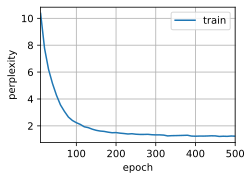

In [11]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, strategy)